In [1]:
import numpy as np
import cv2

import PIL.Image as Image
import os

import matplotlib.pylab as plt

import tensorflow as tf
import tensorflow_hub as hub

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

In [2]:
IMAGE_SHAPE = (224, 224)

classifier = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/4", input_shape=IMAGE_SHAPE+(3,))
])

shape: (576, 576, 3)


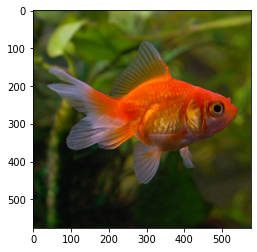

In [3]:
gold_fish=cv2.cvtColor(cv2.imread('goldfish.jpg'),cv2.COLOR_BGR2RGB)
plt.imshow(gold_fish)
print('shape:',gold_fish.shape)

In [4]:
gold_fish = cv2.resize(gold_fish, (224,224), interpolation = cv2.INTER_AREA)
print('shape:',gold_fish.shape)

shape: (224, 224, 3)


In [5]:
print('Max value:',gold_fish.max())
print('Min value:',gold_fish.min())

Max value: 255
Min value: 0


In [6]:
gold_fish=gold_fish/255.

print('Max value:',gold_fish.max())
print('Min value:',gold_fish.min())

Max value: 1.0
Min value: 0.0


In [7]:
gold_fish1 = np.expand_dims(gold_fish, axis=0)
print('shape:',gold_fish1.shape)

shape: (1, 224, 224, 3)


In [8]:
result = classifier.predict(gold_fish1)
result.shape

(1, 1001)

In [9]:
predicted_label_index = np.argmax(result)
predicted_label_index

2

In [10]:
# tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
image_labels = []
with open("ImageNetLabels.txt", "r") as f:
    image_labels = f.read().splitlines()
image_labels[:5]

['background', 'tench', 'goldfish', 'great white shark', 'tiger shark']

Predicted Label: goldfish


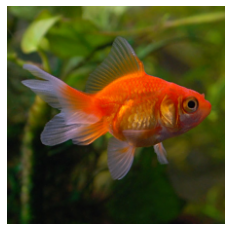

In [11]:
plt.imshow(gold_fish)
plt.axis('off')
print('Predicted Label:',image_labels[np.argmax(result)])

## Flowers dataset

In [12]:
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url,  cache_dir='.', untar=True)

In [13]:
import pathlib
data_dir = pathlib.Path(data_dir)
data_dir

WindowsPath('datasets/flower_photos')

In [14]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


Shape: (279, 320, 3)


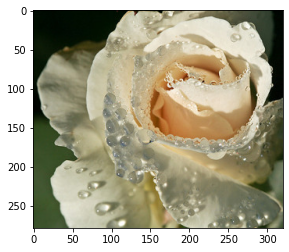

In [15]:
import cv2
import random
num=random.randint(0,len(list(data_dir.glob('roses/*')))-1)
roses = list(data_dir.glob('roses/*'))
plt.imshow(cv2.cvtColor(cv2.imread(str(roses[num])),cv2.COLOR_BGR2RGB))
print('Shape:',cv2.imread(str(roses[num])).shape)

In [16]:
# read images into numpy
flowers_images_dict = {
    'roses': list(data_dir.glob('roses/*')),
    'daisy': list(data_dir.glob('daisy/*')),
    'dandelion': list(data_dir.glob('dandelion/*')),
    'sunflowers': list(data_dir.glob('sunflowers/*')),
    'tulips': list(data_dir.glob('tulips/*')),
}

In [17]:
flowers_labels_dict = {
    'roses': 0,
    'daisy': 1,
    'dandelion': 2,
    'sunflowers': 3,
    'tulips': 4,
}

Shape: (212, 320, 3)


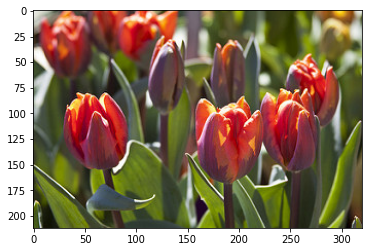

In [18]:
import random
num=random.randint(0,len(flowers_images_dict['tulips'])-1)
plt.imshow(cv2.cvtColor(cv2.imread(str(flowers_images_dict['tulips'][num])),cv2.COLOR_BGR2RGB))
print('Shape:',cv2.imread(str(flowers_images_dict['tulips'][num])).shape)

In [19]:
# preprocessing
X, y = [], []

for flower_name, images in flowers_images_dict.items():
    for image in images:
        img = cv2.imread(str(image))
        resized_img = cv2.resize(img,(224,224))
        X.append(resized_img)
        y.append(flowers_labels_dict[flower_name])

In [20]:
X = np.array(X)
y = np.array(y)

print('Shape of X:',X.shape)
print('Shape of y:',y.shape)

Shape of X: (3670, 224, 224, 3)
Shape of y: (3670,)


In [21]:
# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

In [22]:
# normalize
X_train_scaled = X_train / 255
X_test_scaled = X_test / 255

## Take pre-trained model mobileNet V2

In [23]:
feature_extractor_model = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"

pretrained_model_without_top_layer = hub.KerasLayer(
    feature_extractor_model, input_shape=(224, 224, 3), trainable=False)

In [24]:
num_of_flowers = 5

model = tf.keras.Sequential([
  pretrained_model_without_top_layer,
  tf.keras.layers.Dense(num_of_flowers)
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 5)                 6405      
Total params: 2,264,389
Trainable params: 6,405
Non-trainable params: 2,257,984
_________________________________________________________________


In [25]:
model.compile(
  optimizer="adam",
  loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['acc'])

model.fit(X_train_scaled, y_train, epochs=5)

Epoch 1/5
86/86 [==============================] - 114s 1s/step - loss: 1.1669 - acc: 0.5311
Epoch 2/5
86/86 [==============================] - 103s 1s/step - loss: 0.4280 - acc: 0.8530
Epoch 3/5
86/86 [==============================] - 102s 1s/step - loss: 0.3642 - acc: 0.8848
Epoch 4/5
86/86 [==============================] - 105s 1s/step - loss: 0.2604 - acc: 0.9233
Epoch 5/5
86/86 [==============================] - 106s 1s/step - loss: 0.2331 - acc: 0.9364


In [26]:
model.evaluate(X_test_scaled,y_test)

29/29 [==============================] - 54s 2s/step - loss: 0.3721 - acc: 0.8725


[0.3720724284648895, 0.8725489974021912]

In [27]:
predictions = model.predict(X_test_scaled)

Original Label: sunflowers
Predicted Label: sunflowers


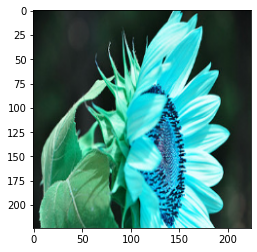

In [31]:
import random
num=random.randint(0,len(y_test)-1)
plt.imshow(X_test_scaled[num])
print('Original Label:',list(flowers_labels_dict.keys())[y_test[num]])
print('Predicted Label:',list(flowers_labels_dict.keys())[np.argmax(predictions[num])])